# Experincing Many Different Circuits

In [1]:
import sys
import numpy as np
import copy
sys.path.append("../")
import qiskit.backends.local.qasm_simulator_cpp as qs
SIM_EXECUTABLE = '../out/src/qasm-simulator-cpp/qasm_simulator_cpp'
CIRCUITS_NUM = 5

relaxation_rate = 1.0
thermal_populations = [1.0, 0.0]

GateErrors = [
#     'measure',
#     'reset',
#     'X90',
    'id',
    'U',
    'CX'
]

def extract_density_matrix(sim_output, circuit_index):
    return sim_output['result'][circuit_index]['data']['snapshots']['0']['density_matrix']

def metric_func(exact_result, approx_result, circuit_index):
    exact_matrix = extract_density_matrix(exact_result, circuit_index)
    approx_matrix = extract_density_matrix(approx_result, circuit_index)
    return np.linalg.norm(exact_matrix - approx_matrix)
    

def matrices_calc(g):
    """
    Returns two matrices of size 2x2:
    E0 = [
            [1,0],
            [0, sqrt(1-g)]
         ]
         
    E1 = [
            [0, sqrt(g)],
            [0,0]
         ]
    """
    assert 0 < g < 1, "Gamma (g) must be between zero to one"
    return [[[1, 0], [0, np.sqrt(1-g)]], [[0, np.sqrt(g)], [0, 0]]]

def calculate_gate_time(g):
    p = g/2 - 0.5*np.sqrt(1-g) + 0.5
    return -(np.log(1-p))/relaxation_rate

def set_amplitude_damping(qobj, gamma):
    E0_E1 = matrices_calc(gamma)
    qobj['config']['noise_params'] = {gate: {'operator_sum': E0_E1}
                                     for gate in GateErrors}
    
def set_relaxation(qobj, gamma):
    gate_time = calculate_gate_time(gamma)
    qobj['config']['noise_params'] = {
        'relaxation_rate': relaxation_rate,
        'thermal_populations': thermal_populations,
        **{gate: {'gate_time': gate_time} for gate in GateErrors}
    }
    
def create_basic_qobj(name, shots, seed):
    return {
        'id': name,
        'config': {
            'shots': shots,
            'seed': seed,
            'backend': 'local_qasm_simulator_cpp',
            'data': ['density_matrix']
        },
        'circuits': []
    }

def enlarge_circuit(circuit):
    new_circuit = copy.deepcopy(circuit)
    new_number_of_qubits = new_circuit['compiled_circuit']['header']['number_of_qubits'] + 2
    new_circuit['compiled_circuit']['header']['number_of_qubits'] = new_number_of_qubits
    new_circuit['compiled_circuit']['header']['number_of_clbits'] = new_number_of_qubits
    new_circuit['compiled_circuit']['header']['clbit_labels'] = [['c', new_number_of_qubits]]
    new_circuit['compiled_circuit']['header']['qubit_labels'].append(['q', new_number_of_qubits-2])
    new_circuit['compiled_circuit']['header']['qubit_labels'].append(['q', new_number_of_qubits-1])
    new_circuit['compiled_circuit']['operations'].insert(-1, {"name": "h", "qubits": [new_number_of_qubits-1]})
    new_circuit['compiled_circuit']['operations'].insert(-1, {"name": "CX", "qubits": [new_number_of_qubits-1, new_number_of_qubits-2]})
    return new_circuit
    
def create_qobj(name, shots, seed):
    qobj = create_basic_qobj(name, shots, seed)
    circuit = {
        'compiled_circuit': {
                    "header": {
                    "number_of_clbits": 0,
                    "number_of_qubits": 0,
                    "clbit_labels": [],
                    "qubit_labels": []
                },
                "operations": [{"name": "snapshot", "params": [0]}]
            }
    }
    for _ in range(CIRCUITS_NUM):
        circuit = enlarge_circuit(circuit)
        qobj['circuits'].append(circuit)
        
    return qobj
    
    
def run_exact(qobj, gamma):
    set_amplitude_damping(qobj, gamma)
    return qs.run(qobj, SIM_EXECUTABLE)

def run_approx(qobj, gamma):
    set_relaxation(qobj, gamma)
    return qs.run(qobj, SIM_EXECUTABLE)



In [2]:
qobj = create_qobj(name="Test", shots=2000, seed=1)
results =[[] for _ in range(CIRCUITS_NUM)]
gamma_range = np.linspace(0, 1, num=100, dtype=float, endpoint=False)[1:]
for gamma in gamma_range:
    exact_results = run_exact(qobj, gamma)
    clifford_results = run_approx(qobj, gamma)
    for i in range(CIRCUITS_NUM):
        results[i].append(metric_func(exact_results, clifford_results, i))


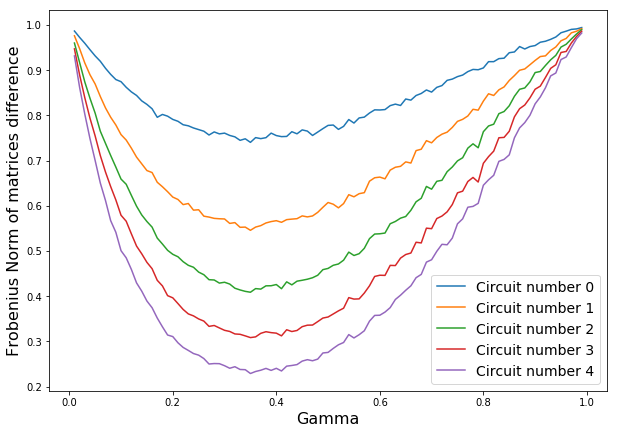

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]

for i in range(CIRCUITS_NUM):
    plt.plot(gamma_range, results[i])


plt.legend(['Circuit number %d' % i for i in range(CIRCUITS_NUM)], loc='best', prop={'size': 14})
plt.xlabel('Gamma', fontsize=16)
plt.ylabel('Frobenius Norm of matrices difference', fontsize=16)
pass